Loading and preprocessing data...


Loading test data: 100%|██████████| 1802/1802 [00:30<00:00, 59.60it/s]



Training model...
16705208/16705208 [==============================] - 5s 0us/step
Epoch 1/30
316/316 [==============================] - ETA: 0s - loss: 44.5703 - mae: 44.5703 - mse: 3364.3381

C:\Users\madha\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


316/316 [==============================] - 278s 862ms/step - loss: 44.5703 - mae: 44.5703 - mse: 3364.3381 - val_loss: 33.4417 - val_mae: 33.4417 - val_mse: 1708.9720 - lr: 0.0010
Epoch 2/30
316/316 [==============================] - 271s 859ms/step - loss: 34.4654 - mae: 34.4654 - mse: 1868.2841 - val_loss: 32.9981 - val_mae: 32.9981 - val_mse: 1753.1097 - lr: 0.0010
Epoch 3/30
316/316 [==============================] - 260s 823ms/step - loss: 34.4059 - mae: 34.4059 - mse: 1861.0323 - val_loss: 33.2519 - val_mae: 33.2519 - val_mse: 1713.9279 - lr: 0.0010
Epoch 4/30
316/316 [==============================] - 254s 803ms/step - loss: 34.5652 - mae: 34.5652 - mse: 1867.9302 - val_loss: 33.1284 - val_mae: 33.1284 - val_mse: 1719.1835 - lr: 0.0010
Epoch 5/30
316/316 [==============================] - 253s 800ms/step - loss: 34.4791 - mae: 34.4791 - mse: 1854.6305 - val_loss: 33.2089 - val_mae: 33.2089 - val_mse: 1715.5460 - lr: 0.0010
Epoch 6/30
316/316 [==============================] - 26

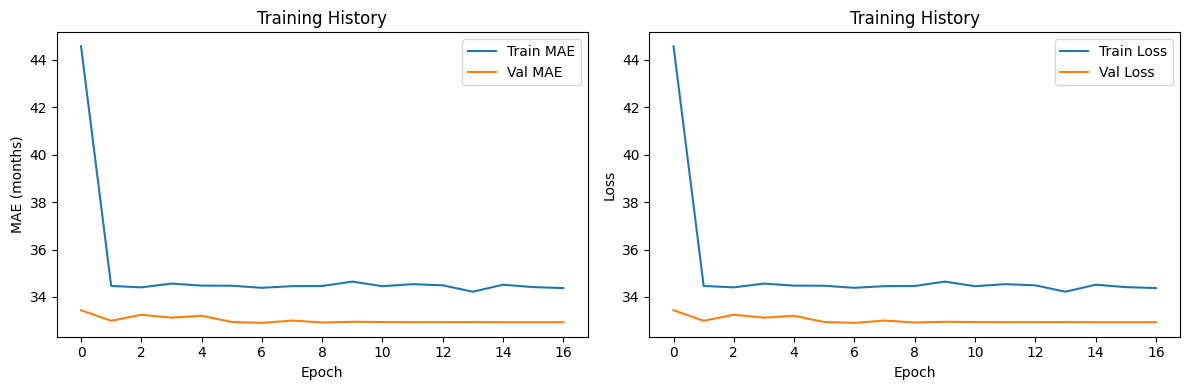


Evaluating model...
79/79 [==============================] - 55s 663ms/step
Validation MAE: 32.91 months
Validation R²: -0.0162


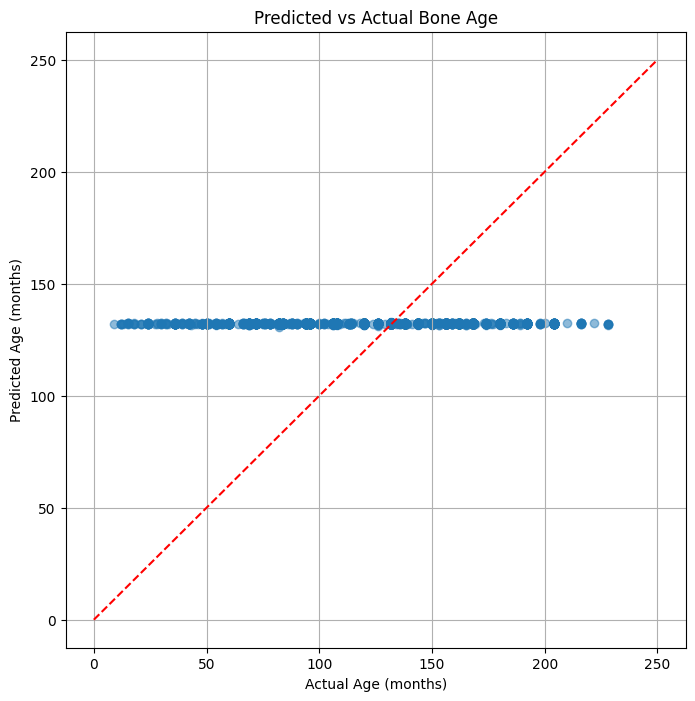


Generating submission file...
57/57 [==============================] - 40s 684ms/step
Submission file saved to submission.csv


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetB0
import cv2
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

###############################################################################
# 1. DATA LOADING AND PREPROCESSING ###########################################
###############################################################################

def load_and_preprocess_data(train_img_dir, train_csv_path, test_img_dir, img_size=(256, 256)):
    """Load and preprocess the bone age dataset"""
    
    # Load training metadata
    train_df = pd.read_csv(train_csv_path)
    train_df.rename(columns={'ID': 'id', 'TARGET': 'bone_age'}, inplace=True)  # Fix column names
    
    # Process training images
    X_train = []
    y_train = []
    
    for _, row in tqdm(train_df.iterrows(), total=len(train_df), desc='Loading training data'):
        img_path = os.path.join(train_img_dir, f"{row['id']}.png")
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue  # Skip if image not found
        img = cv2.resize(img, img_size)
        img = img.astype('float32') / 255.0
        X_train.append(img)
        y_train.append(row['bone_age'])
    
    # Process test images
    X_test = []
    test_ids = []
    
    for img_name in tqdm(os.listdir(test_img_dir), desc='Loading test data'):
        img_path = os.path.join(test_img_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue  # Skip if image not found
        img = cv2.resize(img, img_size)
        img = img.astype('float32') / 255.0
        X_test.append(img)
        test_ids.append(os.path.splitext(img_name)[0])
    
    # Convert grayscale to 3-channel RGB for EfficientNet
    X_train = np.stack([np.array(X_train)] * 3, axis=-1)  # Convert grayscale to RGB
    X_test = np.stack([np.array(X_test)] * 3, axis=-1)
    y_train = np.array(y_train)
    
    # Split into train/validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42)
    
    return X_train, X_val, y_train, y_val, X_test, test_ids

###############################################################################
# 2. MODEL ARCHITECTURE #######################################################
###############################################################################

def build_model(input_shape=(256, 256, 3)):
    """Build EfficientNet-based model for bone age prediction"""
    
    # Input layer
    inputs = layers.Input(shape=input_shape)
    
    # EfficientNet backbone (pretrained on ImageNet)
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',  # Use pretrained weights for better generalization
        input_shape=input_shape,
        pooling='avg'
    )
    base_model.trainable = False  # Freeze the EfficientNet backbone
    
    # Model architecture
    x = base_model(inputs, training=False)  # Ensure frozen state during training
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='linear')(x)
    
    model = models.Model(inputs, outputs)
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='mae',
        metrics=['mae', 'mse']
    )
    
    return model

###############################################################################
# 3. TRAINING PIPELINE ########################################################
###############################################################################

def train_model(X_train, X_val, y_train, y_val):
    """Train the bone age prediction model"""
    
    # Callbacks
    callback_list = [
        callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        callbacks.ModelCheckpoint('best_model.h5', save_best_only=True),
        callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
    ]
    
    # Build model
    model = build_model()
    
    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=32,
        callbacks=callback_list,
        verbose=1
    )
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title('Training History')
    plt.ylabel('MAE (months)')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training History')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model

###############################################################################
# 4. EVALUATION AND PREDICTION ################################################
###############################################################################

def evaluate_model(model, X_val, y_val):
    """Evaluate model performance"""
    predictions = model.predict(X_val).flatten()
    mae = mean_absolute_error(y_val, predictions)
    r2 = r2_score(y_val, predictions)
    
    print(f"Validation MAE: {mae:.2f} months")
    print(f"Validation R²: {r2:.4f}")
    
    # Plot predictions vs true values
    plt.figure(figsize=(8, 8))
    plt.scatter(y_val, predictions, alpha=0.5)
    plt.plot([0, 250], [0, 250], 'r--')
    plt.title('Predicted vs Actual Bone Age')
    plt.xlabel('Actual Age (months)')
    plt.ylabel('Predicted Age (months)')
    plt.grid(True)
    plt.show()

def make_submission(model, X_test, test_ids, output_path='submission.csv'):
    """Generate submission file for competition"""
    predictions = model.predict(X_test).flatten()
    
    submission_df = pd.DataFrame({
        'id': test_ids,
        'bone_age': predictions
    })
    
    submission_df.to_csv(output_path, index=False)
    print(f"Submission file saved to {output_path}")

###############################################################################
# MAIN EXECUTION ##############################################################
###############################################################################

if __name__ == "__main__":
    # Paths to dataset
    TRAIN_IMG_DIR = "E:\ML_IITKanpur\Bone\BoneAge_Dataset\Training_dataset_Boneage"
    TRAIN_CSV_PATH = "E:\ML_IITKanpur\Bone\BoneAge_Dataset\BoneAge_train.csv"
    TEST_IMG_DIR = "E:\ML_IITKanpur\Bone\BoneAge_Dataset\Test_dataset_BoneAge"
    
    # Load and preprocess data
    print("Loading and preprocessing data...")
    X_train, X_val, y_train, y_val, X_test, test_ids = load_and_preprocess_data(
        TRAIN_IMG_DIR, TRAIN_CSV_PATH, TEST_IMG_DIR)
    
    # Train model
    print("\nTraining model...")
    model = train_model(X_train, X_val, y_train, y_val)
    
    # Evaluate model
    print("\nEvaluating model...")
    evaluate_model(model, X_val, y_val)
    
    # Generate submission
    print("\nGenerating submission file...")
    make_submission(model, X_test, test_ids)
